In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
#pip install category_encoders
import category_encoders as ce

from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , RandomizedSearchCV,KFold,RepeatedKFold

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder , LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import get_scorer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import shap
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection  import RFE
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer


from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn import svm 
from sklearn.svm import LinearSVC
from itertools import product
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.inspection import permutation_importance
from IPython.display import display
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, RocCurveDisplay, DetCurveDisplay,PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
import math

In [3]:
df = pd.read_csv('train.csv')
# удалим пока строку,которая нам точно будет не нужна - это ID,модель нужна, чтобы выбросить дубликаты и потом можно тоже убрать
df = df.drop(columns=['ID'])
df.head()

,Brand,Model,Year_of_production,Type,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box,Drive_wheels,Doors,Color,Airbags,Tax,Price
0,OPEL,Combo,2003,Goods wagon,No,Diesel,1.7,152000 km,4.0,Manual,Front,04-May,Grey,2,1438,9408
1,MERCEDES-BENZ,Vito,2008,Minivan,No,Diesel,2.2 Turbo,198700 km,4.0,Manual,Rear,02-Mar,White,6,1195,17000
2,TOYOTA,CHR,2018,Jeep,No,Petrol,2,37214 km,4.0,Automatic,Front,04-May,Grey,10,1079,36065
3,HYUNDAI,Grandeur,2012,Sedan,Yes,Petrol,3,137235 km,4.0,Automatic,Front,04-May,Silver,4,919,15524
4,MERCEDES-BENZ,ML 350,2015,Jeep,Yes,Diesel,3.5,79080 km,6.0,Automatic,4x4,04-May,Grey,12,1273,22894


### Тут идет обработка сета в одном блоке(собрал все манипуляции с файла 2 БЛОКА)

In [301]:
# Функции для обработки колонок с буквами, а также для их разделения
def volume(s):
    if len(s) <= 3:
        a = s
    else:
        a = s[:3]
    return a;

def turbo(df):
    b = []
    for i in range(len(df)):
        if df['Engine_volume'][i][4:] == 'Turbo':
            b.append(1)    
        else:
            b.append(0)
    return pd.Series(b);
# Делаю новую колонку Турбо, чтобы выделять машины с турбированным двигателем
# а также разделяю пробег от километров и делаю из этого целые числа
df['Turbo'] = 0
df['Turbo'] = turbo(df)
df['Engine_volume'] = [volume(i) for i in df['Engine_volume']]
df['Engine_volume'] = df['Engine_volume'].astype(float)
df.Mileage = [int(''.join(filter(str.isdigit, i ))) for i in df.Mileage]

# Ниже буду выбрасывать выброс, которые нашел по графикам
ind = df[df['Engine_volume'] == 0].index
# это некорректные данные, поэтому удаляем их
df = df.drop(index=ind)
inde = df[df['Engine_volume'] == 20].index
df = df.drop(index=inde)
df.Mileage.nlargest(15)
# если загуглить, то можно увидеть, что можно прочитать
# Книги рекордов Гиннеса цифра – 3,2 миллиона миль (5 149 900 км) – датируется маем 2013 года.
# логично, что все пробеги ниже этого очень большого числа подходят под условия
# убираем это большьшое число(удаляем по индексу)
df = df.drop(index = 3169)
# 0 пробег у авто 2010-х годов это очень странно, что на них вообще нет пробега
ind = df[df['Mileage'] == 0].index
df = df.drop(index=ind)
#display(df[df.duplicated()])
# есть дубликаты, поэтому убираем дубликаты
#display(df[df.duplicated()].head(60))
df_duplicates = df.drop('Price', axis = 1)
dupl_rows = df_duplicates[df_duplicates.duplicated()].index
df = df.drop(index=dupl_rows)
df = df.drop_duplicates(keep = 'first')
# удаляем модель, тк эта переменная нам больше не нужна, есть бренд
df = df.drop(columns=['Model'])
display(df[df['Year_of_production'] < 1999].Price)
# Машина за почти за 50000 1995 года будет довольно сильно колебать мое обучение, поэтому считаю выбросом 
# и выбрасываю ее
df = df.drop(index=7146)
df = df[df['Year_of_production'] > 1965]


In [302]:
df.head()

,Brand,Year_of_production,Type,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box,Drive_wheels,Doors,Color,Airbags,Tax,Price,Turbo
0,OPEL,2003,Goods wagon,No,Diesel,1.7,152000,4.0,Manual,Front,04-May,Grey,2,1438,9408,0
1,MERCEDES-BENZ,2008,Minivan,No,Diesel,2.2,198700,4.0,Manual,Rear,02-Mar,White,6,1195,17000,1
2,TOYOTA,2018,Jeep,No,Petrol,2.0,37214,4.0,Automatic,Front,04-May,Grey,10,1079,36065,0
3,HYUNDAI,2012,Sedan,Yes,Petrol,3.0,137235,4.0,Automatic,Front,04-May,Silver,4,919,15524,0
4,MERCEDES-BENZ,2015,Jeep,Yes,Diesel,3.5,79080,6.0,Automatic,4x4,04-May,Grey,12,1273,22894,0


In [303]:
cat_features = ['Brand','Type','Color']
num_features = ['Year_of_production','Mileage','Tax']
y = np.array(df.Price)
X = df.drop(columns=['Price'])
columns = ['Brand','Type','Color','Fuel_type','Gear_box','Drive_wheels','Year_of_production','Mileage','Tax','Leather_interior','Doors','Engine_volume','Cylinders','Airbags','Turbo']

In [315]:
fuel_type_map = [{
    'col':'Fuel_type', 
    'mapping':{'Diesel':3,'Petrol':2,'Hybrid':1,'LPG':0}
    }]
gear_box_map = [{
    'col':'Gear_box',
    'mapping':{'Tiptronic':3,'Automatic':2,'Variator':1,'Manual':0}
    }]
drive_wheels_map = [{
    'col':'Drive_wheels',
    'mapping':{'4x4':2,'Rear':1,'Front':0}
    }]
doors_map = [{
    'col':'Doors',
    'mapping':{'04-May':2,'>5':1,'02-Mar':0}
    }]
leather_interior_map = [{
    'col':'Leather_interior',
    'mapping':{'Yes':1,'No':0}
    }]

fuel_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = fuel_type_map))])

gear_box_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = gear_box_map))])

drive_wheels_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = drive_wheels_map))])

doors_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = doors_map))])

leather_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = leather_interior_map))])

   
# для деревьев можно не стандартизировать данные в фичах 
CT = ColumnTransformer(transformers=[('cat',OrdinalEncoder(),cat_features),
                                     ('fuel_type', fuel_transformer, ['Fuel_type']),
                                     ('gear_box', gear_box_transformer, ['Gear_box']),
                                     ('drive_wheels', drive_wheels_transformer, ['Drive_wheels']),
                                     ('num','passthrough',num_features), #MinMaxScaler()
                                     ('leather',leather_transformer,['Leather_interior']),
                                     ('doors', doors_transformer, ['Doors'])],
                                      remainder = 'passthrough')

display(CT)

X_CT = CT.fit_transform(X)#.toarray()
X_CT = pd.DataFrame(X_CT, columns=columns)
display(X_CT.head())

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OrdinalEncoder(),
                                 ['Brand', 'Type', 'Color']),
                                ('fuel_type',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Fuel_type',
                                                                           'mapping': {'Diesel': 3,
                                                                                       'Hybrid': 1,
                                                                                       'LPG': 0,
                                                                                       'Petrol': 2}}]))]),
                                 ['Fuel_type']),
                                ('gear_box',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Gear_box',
                                                                           'mapping': {'Auto...
                                                                                       'Rear': 1}}]))]),
                                 ['Drive_wheels']),
                                ('num', 'passthrough',
                                 ['Year_of_production', 'Mileage', 'Tax']),
                                ('leather',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Leather_interior',
                                                                           'mapping': {'No': 0,
                                                                                       'Yes': 1}}]))]),
                                 ['Leather_interior']),
                                ('doors',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Doors',
                                                                           'mapping': {'02-Mar': 0,
                                                                                       '04-May': 2,
                                                                                       '>5': 1}}]))]),
                                 ['Doors'])])

,Brand,Type,Color,Fuel_type,Gear_box,Drive_wheels,Year_of_production,Mileage,Tax,Leather_interior,Doors,Engine_volume,Cylinders,Airbags,Turbo
0,31.0,2.0,7.0,3.0,0.0,0.0,2003.0,152000.0,1438.0,0.0,2.0,1.7,4.0,2.0,0.0
1,26.0,6.0,14.0,3.0,0.0,1.0,2008.0,198700.0,1195.0,0.0,0.0,2.2,4.0,6.0,1.0
2,39.0,4.0,7.0,2.0,2.0,0.0,2018.0,37214.0,1079.0,0.0,2.0,2.0,4.0,10.0,0.0
3,16.0,8.0,12.0,2.0,2.0,0.0,2012.0,137235.0,919.0,1.0,2.0,3.0,4.0,4.0,0.0
4,26.0,4.0,7.0,3.0,2.0,2.0,2015.0,79080.0,1273.0,1.0,2.0,3.5,6.0,12.0,0.0


In [310]:
X_train, X_test, y_train, y_test = train_test_split(X_CT, y, test_size= 0.25)

# Random Forest

(0.7, 0.97)

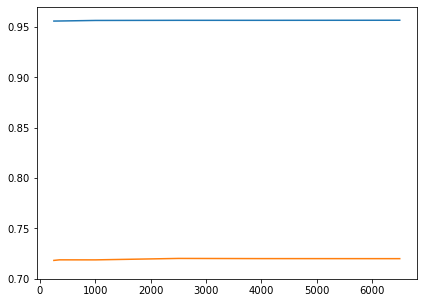

In [219]:
# посмотри на обучение деревьев по графику
sc_train1 =[]
sc_test1 = []
sc_train2 =[]
sc_test2 = []
n_estimators = [250,350,1000,2500,4000,6500]
for n in n_estimators:
    rf = RandomForestRegressor(n_estimators= n, n_jobs = -1)
    rf.fit(X_train, y_train)
    sc_train_n = rf.score(X_train, y_train)
    sc_test_n = rf.score(X_test, y_test)
    sc_train1.append(sc_train_n)
    sc_test1.append(sc_test_n)  
    
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(n_estimators,sc_train1)
ax1.plot(n_estimators,sc_test1)
ax1.set_ylim(0.7,0.97)


# можно увидеть, что идет маленький перегиб(брал до 1000 деревьев) на тестовом наборе в районе 400 деревьев, значит что
#если брать леса, то брать более 400, где идет все стабильно, но для леса чем больше тем и лучше
# результат будет более менее устойчивым, поэтому сильно много брать не надо, тк очень затратно,возможно,но можно и взять
#[250,350,1000,2500,4000] если поставить такие настройки, то можно увидеть маленький маленький перегиб где то от 500
# тоесть в этом случае лучше взять больше 500 ближе к 1000 я думаю
# но если брать [250,350,1000,2500,4000,6500] уже такое, то видно, что идет маленьктй рост с 1000 до 3000 где то
# поэтому стабильно начинается где то уже с 3500
# но какая та "горка" есть около 2500 примерно, проверю рядом с этим числом в сетке

In [285]:
# визуально по графику посмотрим опттимальное количество
# ну логично, что чем больше, тем лучше, но нужно определить оптимальное количество
# чтобы не сильно ело память
# как сказал выше, оптимальное по графику буду брать 3500 где все стабильно и не сильно затратно
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

R2 0.7268037995256523
MSE 59875266.43329388
MAPE 0.3280105386087892


In [287]:
# запущу я его наверное просто для проверки парочки значений
# которые я возьму с графиков
# помимо эстиматоров перебиру еще значений в листьях и посмотрю на результат
model_forest = RandomForestRegressor()

#cv = KFold(n_splits = 10, shuffle = True)

# Параметры для решетки      
n_estimators = [1250,2350,2500,2650,3500]
min_samples_leaf = [1,2,3,4,5]
param_grid = [{
     'n_estimators': n_estimators,
     'min_samples_leaf':min_samples_leaf}]

grid = GridSearchCV(model_forest, param_grid, return_train_score = True, cv=5, n_jobs = -1, scoring= 'r2')
grid.fit(X_train,y_train)
grid

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': [1, 2, 3, 4, 5],
                          'n_estimators': [1250, 2350, 2500, 2650, 3500]}],
             return_train_score=True, scoring='r2')

In [289]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result
# как я примерно и говорил, что на более стабильном участке и результат будет лучше
# я взял не так большое число, например, 5000-10000, тк там по графику видно стабильное значение
# поэтому 3500 это оптимальное значение и с 1 значение в листе,но 1 это дефолт значение
# поэтому просто прописываем кол-во эстиматоров 3500

,4,2,3,5,1,8,6,9,0,7,...,19,15,16,18,17,24,20,22,21,23
mean_fit_time,49.72278,35.112499,37.864673,14.378782,30.714491,30.779775,27.183024,40.973097,15.924648,28.963386,...,37.402139,12.760593,24.038529,27.408618,25.554974,36.365441,12.898374,26.964573,24.451744,31.550967
std_fit_time,0.508391,1.042213,0.433177,0.242278,0.920996,0.146776,0.251901,0.397741,0.118638,0.115372,...,0.514089,0.11312,0.317879,0.169774,0.197729,3.250242,0.44619,0.770196,0.331008,0.473934
mean_score_time,1.132318,1.487675,1.174371,0.295303,1.245409,0.614204,0.555706,0.831185,0.689319,0.592869,...,0.813408,0.259805,0.480883,0.563286,0.530608,0.558722,0.280024,0.607263,0.566998,0.625007
std_score_time,0.063761,0.303214,0.070162,0.00749,0.187636,0.010836,0.010363,0.015111,0.037229,0.008005,...,0.025374,0.005814,0.015989,0.01073,0.012821,0.175062,0.022261,0.050278,0.074282,0.079781
param_min_samples_leaf,1,1,1,2,1,2,2,2,1,2,...,4,4,4,4,4,5,5,5,5,5
param_n_estimators,3500,2500,2650,1250,2350,2650,2350,3500,1250,2500,...,3500,1250,2350,2650,2500,3500,1250,2500,2350,2650
params,"{'min_samples_leaf': 1, 'n_estimators': 3500}","{'min_samples_leaf': 1, 'n_estimators': 2500}","{'min_samples_leaf': 1, 'n_estimators': 2650}","{'min_samples_leaf': 2, 'n_estimators': 1250}","{'min_samples_leaf': 1, 'n_estimators': 2350}","{'min_samples_leaf': 2, 'n_estimators': 2650}","{'min_samples_leaf': 2, 'n_estimators': 2350}","{'min_samples_leaf': 2, 'n_estimators': 3500}","{'min_samples_leaf': 1, 'n_estimators': 1250}","{'min_samples_leaf': 2, 'n_estimators': 2500}",...,"{'min_samples_leaf': 4, 'n_estimators': 3500}","{'min_samples_leaf': 4, 'n_estimators': 1250}","{'min_samples_leaf': 4, 'n_estimators': 2350}","{'min_samples_leaf': 4, 'n_estimators': 2650}","{'min_samples_leaf': 4, 'n_estimators': 2500}","{'min_samples_leaf': 5, 'n_estimators': 3500}","{'min_samples_leaf': 5, 'n_estimators': 1250}","{'min_samples_leaf': 5, 'n_estimators': 2500}","{'min_samples_leaf': 5, 'n_estimators': 2350}","{'min_samples_leaf': 5, 'n_estimators': 2650}"
split0_test_score,0.70403,0.703529,0.704635,0.702056,0.704553,0.701761,0.70188,0.701725,0.702846,0.700316,...,0.691334,0.690374,0.691405,0.691207,0.691494,0.684222,0.684395,0.683578,0.68435,0.684197
split1_test_score,0.684859,0.684726,0.683935,0.686254,0.683644,0.685605,0.685201,0.685766,0.681766,0.685045,...,0.676923,0.676801,0.677689,0.677851,0.676654,0.670954,0.671635,0.670674,0.670086,0.67084
split2_test_score,0.661755,0.660979,0.66153,0.665803,0.6599,0.665843,0.665063,0.66518,0.661101,0.664514,...,0.662857,0.663263,0.661069,0.661597,0.661143,0.658232,0.656755,0.657986,0.656759,0.658183


In [295]:
# тут буду проверять мои результаты
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

R2 0.7215091542884882
MSE 61035671.64279
MAPE 0.32423038238050744


# Gradient Boosting

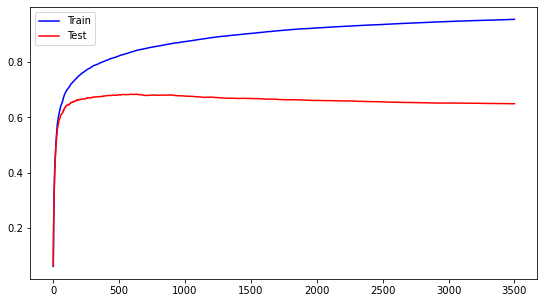

In [260]:
# здесь так то можно перебрать как estimators и также learning rate и возможно выделять для себя самые оптимальные
# возьму парочку, которые гляну в решетке
def plot_learnig_tree(estimator, X_train, X_test, y_train, y_test):  
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(121)
    n_estimators = estimator.n_estimators_
    zero = np.zeros(n_estimators, dtype=np.float64)
    color_one = 'blue'
    color_two = 'red'
    
    train_score = zero
    for i, y_pred_train in enumerate(estimator.staged_predict(X_train)):
        train_score[i] = r2_score(y_train, y_pred_train)
    ax1.plot(
        (np.arange(train_score.shape[0]) + 1),
        train_score,
        "-",
        color=color_one,
        label='Train',
        )
        
    test_score = zero
    for i, y_pred_test in enumerate(estimator.staged_predict(X_test)):
        train_score[i] = r2_score(y_test, y_pred_test)    
    ax1.plot(
        (np.arange(test_score.shape[0]) + 1),
        train_score,
        "-",
        color = color_two,
        label='Test',
        )
    ax1.legend(loc='best')

# возьму результат с деревьев и посмотрю на 3500
# посмотрю learning rate
clf = GradientBoostingRegressor(n_estimators=3500,random_state=42, learning_rate = 0.1)
clf.fit(X_train, y_train)
plot_learnig_tree(clf, X_train, X_test, y_train, y_test)
#при learning rate 0.1 на тесте результат ухудшается по мере увеличения деревьев(оптимум где то на 500-600)
# при большом learning rate очень сильно страдает тест
# определю оптимальные и закину в решетку

In [280]:
# тут буду проверять визуальные значения
# про прверке выделил пару значений, которые проверю через решетку
gr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=600)
gr.fit(X_train,y_train)
gr.score(X_train,y_train)
y_predict = gr.predict(X_test)
print('R2',r2_score(y_test,y_predict))
print('MSE', mean_squared_error(y_test,y_predict))
print('MAPE',mean_absolute_percentage_error(y_test,y_predict))

R2 0.6815392525650352
MSE 69795707.51023255
MAPE 0.35796028411570374


In [278]:
# запущу я его наверное просто для проверки парочки значения
model_boosting = GradientBoostingRegressor()

#cv = KFold(n_splits = 1, shuffle = True) # для моделей основанных на лесах это не нужно
                                          # поэтому ставим минимальный
# Параметры для решетки    
learning_rate  = [0.1,0.95,0.05,0.01]
n_estimators = [250,550,600,1250]

param_grid = [{
     'n_estimators': n_estimators,
     'learning_rate': learning_rate}]

grid = GridSearchCV(model_boosting, param_grid, return_train_score = True, cv=2, n_jobs = -1,scoring= 'r2')
grid.fit(X_train,y_train)
grid

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.1, 0.95, 0.05, 0.01],
                          'n_estimators': [250, 550, 600, 1250]}],
             return_train_score=True, scoring='r2')

In [279]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result
# на уровне 0.1 learning rate - оптимум был где то от 500-600
# попало 550 - значит возьму его

,1,2,11,10,9,0,3,8,15,14,13,4,12,6,5,7
mean_fit_time,1.322847,1.440342,3.015222,1.416026,1.293263,0.59204,3.003715,0.585844,2.544848,1.472289,1.371846,0.632496,0.610852,1.430282,1.308332,2.979449
std_fit_time,0.012469,0.000399,0.009377,0.016508,0.004438,0.00384,0.036329,0.00029,0.018002,0.009427,0.007951,0.001728,0.000485,0.002446,0.006691,0.018339
mean_score_time,0.019361,0.016487,0.029306,0.018906,0.020886,0.010496,0.036615,0.0128,0.032765,0.023708,0.027931,0.008469,0.009929,0.019281,0.017395,0.046568
std_score_time,0.002135,0.001844,0.000457,0.00172,0.001915,0.001198,0.001662,0.000165,0.00087,0.000226,0.005952,0.001762,0.000524,0.000462,0.000774,0.004685
param_learning_rate,0.1,0.1,0.05,0.05,0.05,0.1,0.1,0.05,0.01,0.01,0.01,0.95,0.01,0.95,0.95,0.95
param_n_estimators,550,600,1250,600,550,250,1250,250,1250,600,550,250,250,600,550,1250
params,"{'learning_rate': 0.1, 'n_estimators': 550}","{'learning_rate': 0.1, 'n_estimators': 600}","{'learning_rate': 0.05, 'n_estimators': 1250}","{'learning_rate': 0.05, 'n_estimators': 600}","{'learning_rate': 0.05, 'n_estimators': 550}","{'learning_rate': 0.1, 'n_estimators': 250}","{'learning_rate': 0.1, 'n_estimators': 1250}","{'learning_rate': 0.05, 'n_estimators': 250}","{'learning_rate': 0.01, 'n_estimators': 1250}","{'learning_rate': 0.01, 'n_estimators': 600}","{'learning_rate': 0.01, 'n_estimators': 550}","{'learning_rate': 0.95, 'n_estimators': 250}","{'learning_rate': 0.01, 'n_estimators': 250}","{'learning_rate': 0.95, 'n_estimators': 600}","{'learning_rate': 0.95, 'n_estimators': 550}","{'learning_rate': 0.95, 'n_estimators': 1250}"
split0_test_score,0.657441,0.65604,0.655717,0.656654,0.6558,0.651817,0.637926,0.622473,0.61579,0.567367,0.560287,0.506356,0.466645,0.484895,0.483099,0.478786
split1_test_score,0.668892,0.667547,0.667313,0.660102,0.658731,0.657361,0.65424,0.63964,0.637462,0.597653,0.59227,0.485152,0.510195,0.459041,0.458454,0.448236
mean_test_score,0.663167,0.661793,0.661515,0.658378,0.657266,0.654589,0.646083,0.631056,0.626626,0.58251,0.576278,0.495754,0.48842,0.471968,0.470777,0.463511


In [281]:
gr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=550)
gr.fit(X_train,y_train)
gr.score(X_train,y_train)
y_predict = gr.predict(X_test)
print('R2',r2_score(y_test,y_predict))
print('MSE', mean_squared_error(y_test,y_predict))
print('MAPE',mean_absolute_percentage_error(y_test,y_predict))

R2 0.6809418336011094
MSE 69926641.32108077
MAPE 0.35826865751297954


## Сравнение 2 моделей

In [ ]:
# Леса и Бустинг

In [296]:
# тут буду проверять мои результаты
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)

gr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=550)
gr.fit(X_train,y_train)
gr.score(X_train,y_train)
y_predict = gr.predict(X_test)

print('R2_Forest',r2_score(y_test,y_pred))
print('R2_Boosting',r2_score(y_test,y_predict))
print('--------')
print('MSE_Forest', mean_squared_error(y_test,y_pred))
print('MSE_Boosting', mean_squared_error(y_test,y_predict))
print('--------')
print('MAPE_Forest',mean_absolute_percentage_error(y_test,y_pred))
print('MAPE_Boosting',mean_absolute_percentage_error(y_test,y_predict))

R2_Forest 0.7202969633762133
R2_Boosting 0.6817587327202699
--------
MSE_Forest 61301342.44536505
MSE_Boosting 69747604.96433814
--------
MAPE_Forest 0.32471991801687694
MAPE_Boosting 0.3579358224174281


### Тут видно, что RandomForest показывает лучшие результаты в сравние с другой моделью, поэтому за основную модель буду брать именно его, и проводить дальнейшие преобразование с данными в других файлах с этой моделью  =>  RandomForestRegressor(n_estimators = 3500)